# Importing Libraries and Reading Data

In [89]:
import asyncio
import base64
import datetime
import functools
import os
import time
import warnings

import aiohttp
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from IPython.display import display
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

nest_asyncio.apply()

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.float_format", lambda f: "%.2f" % f)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
warnings.filterwarnings("ignore")

print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))

df = pd.read_csv("../../data/security_score.csv", delimiter=",", thousands=",", na_values="", index_col=None)
df.drop(["recommendationId", "recommendationName", "resourceId", "resourceGroup", "controls", "techniques", "subscriptionId", "exportedTimestamp", "cloud", "azurePortalRecommendationLink", "tactics", "owner", "eta", "dueDate", "gracePeriod", "statusChangeDate", "firstEvaluationDate", "nativeCloudAccountId"], axis=1, inplace=True)

model name	: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
model name	: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
model name	: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
model name	: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
model name	: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
model name	: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
model name	: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
model name	: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
0
MemTotal:       16061280 kB
0


# Checking NULL Values

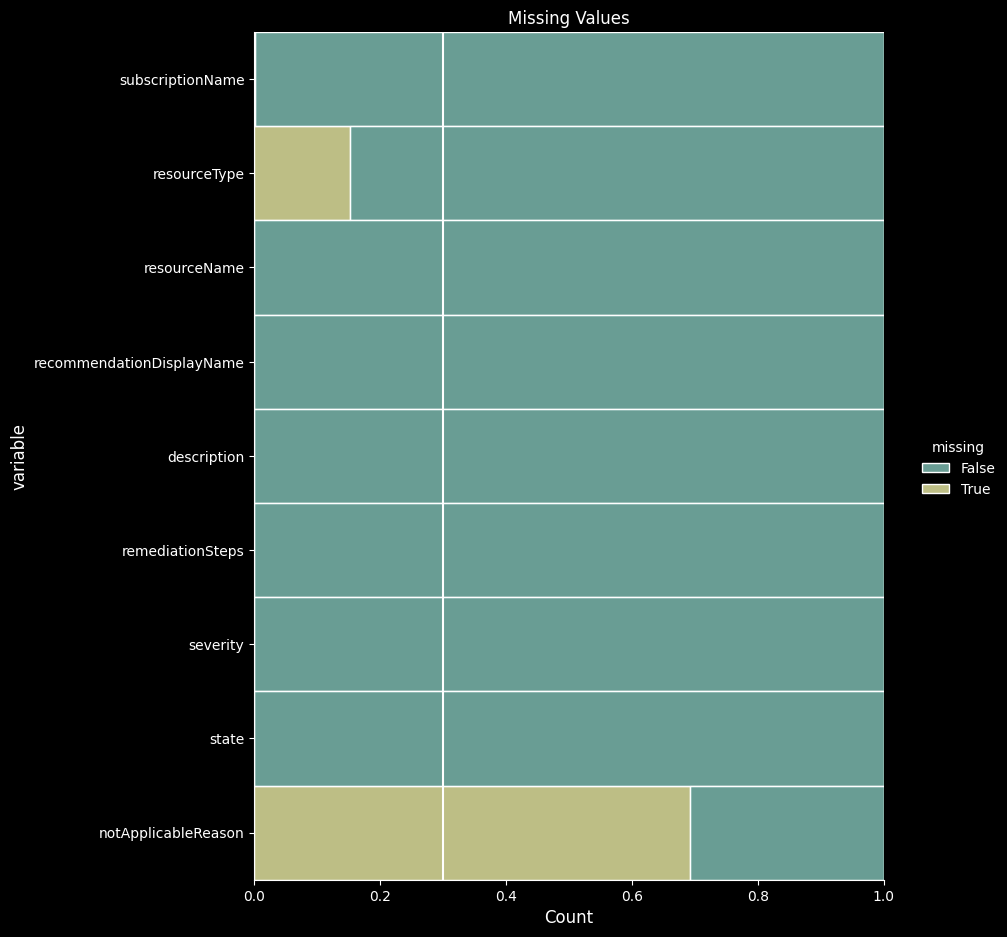

In [90]:
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25,
)
plt.axvline(0.3, color="white")
plt.title("Missing Values")
plt.show()

# API OAuth2 Headers

In [91]:
(
    graph_api_headers,
    rest_api_headers,
    devops_api_headers,
    devops_pat_headers,
    ea_api_headers,
) = [""] * 5


def timer(func):
    if asyncio.iscoroutinefunction(func):

        @functools.wraps(func)
        async def wrapper(*args, **kwargs):
            start_time = time.time()
            await func(*args, **kwargs)
            print(f"total runtime for async func: {time.time() - start_time}")

        return wrapper
    else:

        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            start_time = time.time()
            func(*args, **kwargs)
            print(f"total runtime for sync func: {time.time() - start_time}")

        return wrapper


def get_api_headers_decorator(func):
    @functools.wraps(func)
    async def wrapper(session, *args, **kwargs):
        return {
            "Authorization": f"Basic {base64.b64encode(bytes(os.environ[args[0]], 'utf-8')).decode('utf-8')}"
            if "PAT" in args[0]
            else f"Bearer {os.environ[args[0]] if 'EA' in args[0] else await func(session, *args, **kwargs)}",
            "Content-Type": "application/json-patch+json"
            if "PAT" in args[0]
            else "application/json",
        }

    return wrapper


@get_api_headers_decorator
async def get_api_headers(session, *args, **kwargs):
    oauth2_headers = {"Content-Type": "application/x-www-form-urlencoded"}
    oauth2_body = {
        "client_id": os.environ[args[0]],
        "client_secret": os.environ[args[1]],
        "grant_type": "client_credentials",
        "scope" if "GRAPH" in args[0] else "resource": args[2],
    }
    async with session.post(
        url=args[3], headers=oauth2_headers, data=oauth2_body
    ) as resp:
        return (await resp.json())["access_token"]


@timer
async def main(params):
    global graph_api_headers, rest_api_headers, devops_api_headers, devops_pat_headers, ea_api_headers
    async with aiohttp.ClientSession() as session:
        (
            graph_api_headers,
            rest_api_headers,
            devops_api_headers,
            devops_pat_headers,
            ea_api_headers,
        ) = await asyncio.gather(
            *(get_api_headers(session, *param) for param in params)
        )


if __name__ == "__main__":
    params = [
        [
            "GRAPH_CLIENT_ID",
            "GRAPH_CLIENT_SECRET",
            "https://graph.microsoft.com/.default",
            f"https://login.microsoftonline.com/{os.environ['TENANT_ID']}/oauth2/v2.0/token",
        ],
        [
            "REST_CLIENT_ID",
            "REST_CLIENT_SECRET",
            "https://management.azure.com",
            f"https://login.microsoftonline.com/{os.environ['TENANT_ID']}/oauth2/token",
        ],
        [
            "DEVOPS_CLIENT_ID",
            "DEVOPS_CLIENT_SECRET",
            "https://management.azure.com",
            f"https://login.microsoftonline.com/{os.environ['TENANT_ID']}/oauth2/token",
        ],
        ["DEVOPS_PAT_TOKEN"],
        ["PRIMARY_EA_API_TOKEN"],
    ]
    asyncio.run(main(params))

total runtime for async func: 0.581301212310791


# Graph API Calls to fetch Management Group Structure

In [92]:
df_mg = pd.json_normalize(requests.post("https://management.azure.com/providers/Microsoft.Management/getEntities?api-version=2020-05-01", headers=rest_api_headers).json()["value"])
df_mg = df_mg[df_mg["type"] == "/subscriptions"]
df_mg["mg0"] = df_mg["properties.parentDisplayNameChain"].str.get(-1)
df_mg[["Management", "mg2", "Department", "mg4"]] = df_mg["mg0"].astype(str).str.split("_", expand=True)
df_mg = df_mg[df_mg["Management"].isin(["Cenitex", "Customer", "Tier"])]
df_mg["Department"].replace({np.nan: "Cenitex", "Dev": "Cenitex"}, inplace=True)
df_mg["Management"].replace({"Cenitex": "Cenitex Managed", "Customer": "Customer Managed", "Tier": "T0"}, inplace=True)
df_mg = df_mg[["properties.displayName", "Management", "Department"]]
df_mg.columns = ["subscriptionName", "management", "department"]

# Merging Security Score Table with Management Group Table

In [93]:
df = pd.merge(left=df, right=df_mg, left_on="subscriptionName", right_on="subscriptionName", how="left")

# Feature Description

In [ ]:
col_cat_oe = []
preprocessor_cat_oe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OrdinalEncoder(categories=[["", ""]])),
)
col_cat = [col for col in df.columns if np.issubsctype(df[col].dtype, np.object0)]
col_num = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number)]
col_cat_ohe = [col for col in col_cat if col not in col_cat_oe]
col_num_disc = [col for col in col_num if df[col].nunique() <= 10]
col_num_cont = [col for col in col_num if col not in col_num_disc]

df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if col in col_num else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "kurtosis": [f"{df[col].kurtosis(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [sorted(df[col].unique()) if col in col_num else df[col].unique() for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")


# Exporting Data

In [95]:
df.columns = ["".join(f" {c}" if c.isupper() else c for c in col).title() for col in df.columns]
df.dropna(subset=["Department"], axis=0, inplace=True)
df.to_csv("security_score.csv", index=False)